![logo](../../_static/images/NCI_logo.png)

-------

# GSKY Click and Ship


**The following libraries will need to be imported for the below example.** 

In [1]:
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
%matplotlib inline

### Preview available data

**Let's preview the available data first with WMS**

In [2]:
gsky_url = 'http://gsky.nci.org.au/ows/dea'

In [3]:
wms = WebMapService(gsky_url, version='1.3.0')

**Find out the available data layers that can be requested:**

In [4]:
for layer in list(wms.contents):
    print("Layer Name:", wms[layer].name)
    print("Title:", wms[layer].title, '\n')

Layer Name: blend_sentinel2_landsat_nbart_daily_false_colour
Title: Multi-sensor (Landsat and Sentinel 2) surface reflectance false colour (Beta) 

Layer Name: blend_sentinel2_landsat_nbart_daily_true_colour
Title: Multi-sensor (Landsat and Sentinel 2) surface reflectance true colour (Beta) 

Layer Name: hltc_high
Title: DEA High Tide Composite 25m v2.0 

Layer Name: hltc_low
Title: DEA Low Tide Composite 25m v2.0 

Layer Name: item_relative
Title: DEA Intertidal Extents Model Relative Layer 25m v2.0 

Layer Name: item_stddev
Title: DEA Intertidal Extents Model Confidence Layer 25m v2.0 

Layer Name: landsat5_geomedian
Title: DEA Landsat 5 terrain corrected surface reflectance geometric median 

Layer Name: landsat5_nbar_16day
Title: 16-day DEA Landsat 5 surface reflectance 

Layer Name: landsat5_nbar_daily
Title: Daily DEA Landsat 5 surface reflectance 

Layer Name: landsat5_nbart_16day
Title: 16-day DEA Landsat 5 terrain corrected surface reflectance 

Layer Name: landsat5_nbart_dail

**We can also view metadata that is available about a selected layer. For example, you can view the abstract associated with that data layer.** 

In [9]:
layer = "blend_sentinel2_landsat_nbart_daily_false_colour"

In [10]:
print(wms[layer].abstract)

This multi-sensor service has been corrected to remove the influences of the atmosphere, the time of year, terrain shadow and satellite view angles using the methods described in Li et al. 2012 https://doi.org/10.1016/j.rse.2012.06.018. This service combines terrain corrected surface reflectance observations from three Landsat sensors (Landsat 5 TM, Landsat 7 ETM+, Landsat 8 OLI) and two Sentinel 2 sensors (Sentinel 2A and 2B). More detailed information about the terrain corrected surface reflectance product suite produced using Digital Earth Australia including CCBY4.0 is available at http://dx.doi.org/10.4225/25/5a7a76d2e129e. The service for each day is composed from all acquisitions that occurred over the Australian region on that calendar day.


In [11]:
print(wms[layer].styles)

{'fc': {'title': 'False colour'}}


**Let's request a preview of the dataset through WMS**

**WMS function**

In [12]:
def get_map(layer, bbox, time, Styles):
    output = wms.getmap(layers=[layer],
                        srs=wms[layer].crsOptions[0], 
                        bbox=bbox,
                        size=(256, 256), 
                        format='image/png',
                        time=time,
                        Styles=style
                        )
    
    pngfile = './gsky_getMap.png'
    with open(pngfile, 'wb') as out:
        out.write(output.read())
        
    return pngfile

**Make a request**

In [48]:
subset_bbox = (150.5, -36.5, 151, -36)

In [58]:
print("Time Positions: ")
time = wms[layer].timepositions
print('\t', time[:10], '\n')

Time Positions: 
	 ['1986-08-15T00:00:00.000Z', '1986-08-16T00:00:00.000Z', '1986-08-17T00:00:00.000Z', '1986-08-18T00:00:00.000Z', '1986-08-19T00:00:00.000Z', '1986-08-20T00:00:00.000Z', '1986-08-21T00:00:00.000Z', '1986-08-22T00:00:00.000Z', '1986-08-23T00:00:00.000Z', '1986-08-24T00:00:00.000Z'] 



In [50]:
print(wms[layer].styles)

{'fc': {'title': 'False colour'}}


In [51]:
style = 'tc'

**Make sure to choose the time stamp where data exists, otherwise, you will get a blank image.**

In [93]:
pngfile = get_map(layer, subset_bbox, time[10008], style)

#### And if we'd like to confirm the result:

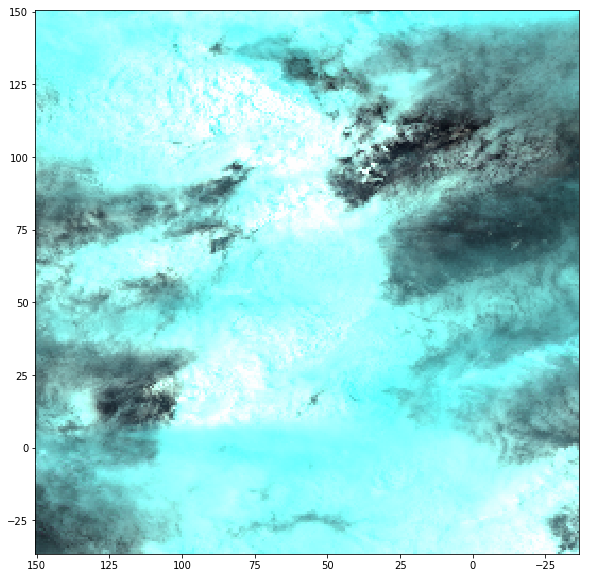

In [94]:
im = Image.open(pngfile)
plt.figure(figsize=(10, 10))
plt.imshow(im, extent=[subset_bbox[0], subset_bbox[1], subset_bbox[1], subset_bbox[0]])

In [144]:
def get_coverage(layer, Styles, bbox, time):
    wcs = WebCoverageService(gsky_url, version='1.0.0')
    output = wcs.getCoverage(identifier=layer,
                             Styles=style,
                             time=time,
                             bbox=subset_bbox,
                             format='NetCDF',
                             crs='EPSG:4326', 
                             width=256, 
                             height=256)

    
    filename = './gsky_wcs.nc'
    with open(filename, 'wb') as f:
        f.write(output.read())
        
    return filename

### Select/click region 

In [156]:
lon_range = widgets.IntRangeSlider(
    value=[135, 145],
    min=110,
    max=155,
    step=1,
    description='Longitude:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

lat_range = widgets.IntRangeSlider(
    value=[-30, -25],
    min=-45,
    max=-10,
    step=1,
    description='Latitude:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [157]:
display(lon_range)
display(lat_range)

IntRangeSlider(value=(135, 145), continuous_update=False, description='Longitude:', max=155, min=110)

IntRangeSlider(value=(-30, -25), continuous_update=False, description='Latitude:', max=-10, min=-45)

In [158]:
print('latitude = {0}'.format(lat_range.value))
print('longitude = {0}'.format(lon_range.value))

latitude = (-30, -25)
longitude = (135, 145)


In [159]:
subset = (lon_range.value[0], lat_range.value[0], lon_range.value[1], lon_range.value[1])

In [160]:
layer = "landsat8_nbart_16day"
style = 'fc'

### And ship!

In [161]:
wcs_output = get_coverage(layer, style, subset, time[10008])

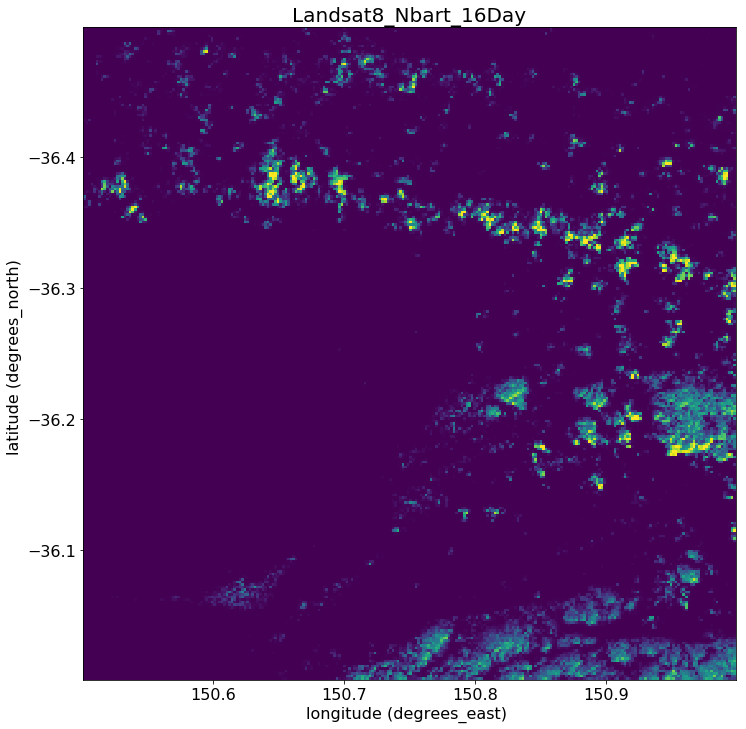

In [162]:
with Dataset(wcs_output) as ds:
    
    band = ds['Band1']
    lon = ds['lon']
    lat = ds['lat']


    # Set figure size
    plt.figure(figsize=(12,12))

    # Plot image
    plt.imshow(band, extent=[lon[0], lon[-1], lat[-1], lat[0]])

    # Add figure title and labels
    # We can make use of the defined variable attributes to do this
    plt.title(layer.title(), fontsize=20)
    plt.xlabel(lon.long_name+' ('+lon.units+') ', fontsize=16)
    plt.ylabel(lat.long_name+' ('+lat.units+') ', fontsize=16)


    # Adjust tick mark size
    plt.tick_params(labelsize=16)

<br>
<br>
<br>


--------
**For more information on the OGC WMS standard specifications and the Python OWSLib package:** <br/>

- http://www.opengeospatial.org/standards/wms <br/>

- https://geopython.github.io/OWSLib/#wms <br/>
